In [17]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

SET THÔNG SỐ

TẠO ENCODER DECODER CHANNEL

In [18]:
class AutoEncoder(nn.Module):
    def __init__(self, M, n_channel, snr_db):
        super(AutoEncoder, self).__init__()
        self.M = M
        self.n_channel = n_channel
        self.snr_db = snr_db  # Lưu snr_db thành biến instance

        self.encoder = nn.Sequential(
            nn.Linear(M, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, n_channel)
        )

        self.decoder = nn.Sequential(
            nn.Linear(n_channel, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, M)
        )

    def add_awgn_noise(self, x):
        signal_power = torch.mean(x.pow(2), dim=1, keepdim=True)
        noise_power = signal_power * 10 ** (-self.snr_db / 10)
        noise_std = torch.sqrt(noise_power / 2)
        noise = torch.randn_like(x) * noise_std
        return x + noise

    def forward(self, x):
        x = self.encoder(x)
        x = F.normalize(x, p=2, dim=1)
        rayleigh_fading = torch.sqrt(torch.randn_like(x)**2 + torch.randn_like(x)**2) / math.sqrt(2)
        x_faded = x * rayleigh_fading
        x_noisy = self.add_awgn_noise(x_faded)
        out = self.decoder(x_noisy)
        return out


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def generate_data(batch_size): #tạo ra 1 batch_size
    labels = torch.randint(0, M, (batch_size,)) #tạo label cho từng batch_size từ 0 đến M
    x = F.one_hot(labels, num_classes=M).float() #tương ứng với mỗi labels đưa về one_hot có độ dài là M
    return x.to(device), labels.to(device)

SNR(dB): -10.0, Accuracy: 0.0232
SNR(dB): -9.5, Accuracy: 0.0233
SNR(dB): -9.0, Accuracy: 0.0232
SNR(dB): -8.5, Accuracy: 0.0242
SNR(dB): -8.0, Accuracy: 0.0254
SNR(dB): -7.5, Accuracy: 0.0252
SNR(dB): -7.0, Accuracy: 0.0253
SNR(dB): -6.5, Accuracy: 0.0262
SNR(dB): -6.0, Accuracy: 0.0269
SNR(dB): -5.5, Accuracy: 0.0271
SNR(dB): -5.0, Accuracy: 0.0283
SNR(dB): -4.5, Accuracy: 0.0288
SNR(dB): -4.0, Accuracy: 0.0287
SNR(dB): -3.5, Accuracy: 0.0299
SNR(dB): -3.0, Accuracy: 0.0329
SNR(dB): -2.5, Accuracy: 0.0338
SNR(dB): -2.0, Accuracy: 0.0362
SNR(dB): -1.5, Accuracy: 0.0386
SNR(dB): -1.0, Accuracy: 0.0430
SNR(dB): -0.5, Accuracy: 0.0448
SNR(dB): 0.0, Accuracy: 0.0533
SNR(dB): 0.5, Accuracy: 0.0571
SNR(dB): 1.0, Accuracy: 0.0631
SNR(dB): 1.5, Accuracy: 0.0667
SNR(dB): 2.0, Accuracy: 0.0723
SNR(dB): 2.5, Accuracy: 0.0775
SNR(dB): 3.0, Accuracy: 0.0822
SNR(dB): 3.5, Accuracy: 0.0860
SNR(dB): 4.0, Accuracy: 0.0907
SNR(dB): 4.5, Accuracy: 0.0966
SNR(dB): 5.0, Accuracy: 0.1004
SNR(dB): 5.5, Accu

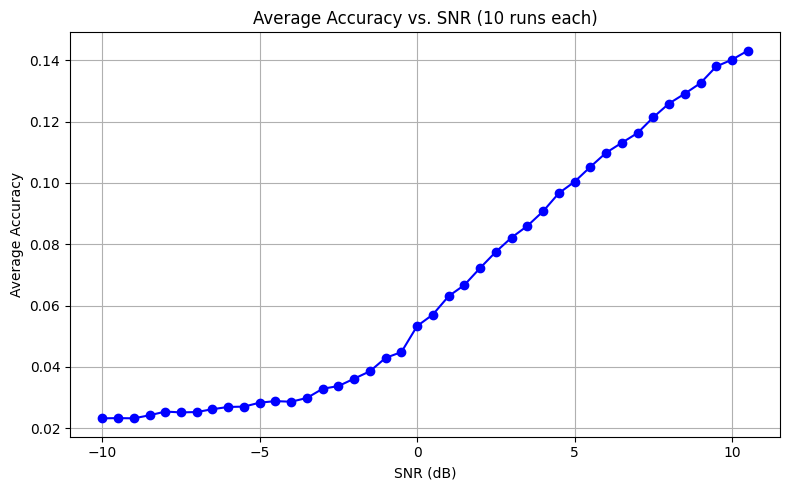

In [20]:
snr_range = np.arange(-10, 11, 0.5)  # Từ -10 dB đến 10 dB
accuracies = []

M = 64
k = int(torch.log2(torch.tensor(M)))
n_channel = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

repeat_times = 100  # Số lần lặp huấn luyện mỗi mức SNR
num_epochs = 1000   # Epoch mỗi lần huấn luyện
batch_size = 1024

for snr_db in snr_range:
    acc_temp = []

    for repeat in range(repeat_times):
        model = AutoEncoder(M, n_channel, snr_db).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(num_epochs):
            model.train()
            x, labels = generate_data(batch_size)
            x, labels = x.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Đánh giá sau huấn luyện
        model.eval()
        with torch.no_grad():
            x_test, labels_test = generate_data(2048)
            x_test, labels_test = x_test.to(device), labels_test.to(device)
            outputs = model(x_test)
            preds = torch.argmax(outputs, dim=1)
            acc = (preds == labels_test).float().mean().item()
            acc_temp.append(acc)

    acc_avg = np.mean(acc_temp)
    accuracies.append(acc_avg)
    print(f"SNR(dB): {snr_db}, Accuracy: {acc_avg:.4f}")

# Vẽ đồ thị
plt.figure(figsize=(8, 5))
plt.plot(snr_range, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel("SNR (dB)")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy vs. SNR (10 runs each)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
# Đánh giá sau khi huấn luyện
model.eval()
with torch.no_grad():
    x_test, labels_test = generate_data(1000)
    outputs_test = model(x_test)
    pred = torch.argmax(outputs_test, dim=1)
    acc = (pred == labels_test).float().mean()
    print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.1600
